# Stock Market Returns Analysis: Developed, Emerging & Frontier Markets (2000-2024)

## Overview
This notebook analyzes wealth generation across 15 countries categorized into **Developed**, **Emerging**, and **Frontier** markets over the period 2000-2024.

### Portfolio Composition
- **Developed Markets (5)**: USA, Germany, Japan, UK, Australia
- **Emerging Markets (5)**: China, India, Brazil, Indonesia, Mexico  
- **Frontier Markets (5)**: Pakistan, Argentina, Turkey, Egypt, Vietnam

### Methodology

#### Data Sources
1. **USD View**: US-listed Total Return ETFs (e.g., SPY, EWG, PAK)
   - Includes dividends
   - Currency standardized to USD
   - Handles different inception dates (e.g., Pakistan ETF starts 2015)

2. **Local View**: Local market indices (e.g., ^GDAXI, ^KSE)
   - Local currency prices
   - May not include dividends

3. **Inflation Data**: World Bank CPI annual inflation rates via `wbgapi`

#### Data Processing
- **Bad Data Handling**: Replaces 0.0 prices with NaN (prevents crashes)
- **Smoothing**: Monthly resampling to reduce noise
- **Gap Filling**: Forward fill for missing days

#### Return Types
1. **USD Nominal**: Raw ETF performance in USD
2. **USD Real**: ETF performance adjusted for US inflation
3. **Local Real**: Local index performance adjusted for local inflation

### Visualizations
Three chart sets with 3 subplots each (Developed/Emerging/Frontier):
- Dark mode styling
- Fixed calendar range (2000-2024)
- Linear scale from 0
- Baseline at $1,000 initial investment

---

## Installation Requirements
```bash
pip install yfinance wbgapi pandas numpy matplotlib
```

## Usage
Run all cells sequentially. The analysis will:
1. Fetch ETF and local index data
2. Retrieve inflation data from World Bank
3. Clean and process all data
4. Calculate nominal and real returns
5. Generate visualizations and summary tables

---

**Note**: Internet connection required for data fetching. First run may take 2-3 minutes.

In [40]:
# Imports and Configuration
import yfinance as yf
import pandas as pd
import wbgapi as wb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration
START_DATE = '2000-01-01'
END_DATE = '2024-12-31'

print("Libraries imported successfully")
print(f"Analysis Period: {START_DATE} to {END_DATE}")
print("="*80)

Libraries imported successfully
Analysis Period: 2000-01-01 to 2024-12-31


In [41]:
# Portfolio Configuration
# Each country has local currency ticker and USD ETF ticker

PORTFOLIO = {
    # Developed Markets
    'USA': {
        'type': 'Developed',
        'local_ticker': '^GSPC',      # S&P 500
        'usd_ticker': 'SPY',          # SPDR S&P 500 ETF
        'wb_code': 'USA'
    },
    'Germany': {
        'type': 'Developed',
        'local_ticker': '^GDAXI',     # DAX
        'usd_ticker': 'EWG',          # iShares MSCI Germany ETF
        'wb_code': 'DEU'
    },
    'Japan': {
        'type': 'Developed',
        'local_ticker': '^N225',      # Nikkei 225
        'usd_ticker': 'EWJ',          # iShares MSCI Japan ETF
        'wb_code': 'JPN'
    },
    'UK': {
        'type': 'Developed',
        'local_ticker': '^FTSE',      # FTSE 100
        'usd_ticker': 'EWU',          # iShares MSCI United Kingdom ETF
        'wb_code': 'GBR'
    },
    'Australia': {
        'type': 'Developed',
        'local_ticker': '^AXJO',      # ASX 200
        'usd_ticker': 'EWA',          # iShares MSCI Australia ETF
        'wb_code': 'AUS'
    },
    
    # Emerging Markets
    'China': {
        'type': 'Emerging',
        'local_ticker': '000001.SS',  # SSE Composite
        'usd_ticker': 'MCHI',         # iShares MSCI China ETF
        'wb_code': 'CHN'
    },
    'India': {
        'type': 'Emerging',
        'local_ticker': '^BSESN',     # BSE Sensex
        'usd_ticker': 'INDA',         # iShares MSCI India ETF
        'wb_code': 'IND'
    },
    'Brazil': {
        'type': 'Emerging',
        'local_ticker': '^BVSP',      # Bovespa
        'usd_ticker': 'EWZ',          # iShares MSCI Brazil ETF
        'wb_code': 'BRA'
    },
    'Indonesia': {
        'type': 'Emerging',
        'local_ticker': '^JKSE',      # Jakarta Composite
        'usd_ticker': 'EIDO',         # iShares MSCI Indonesia ETF
        'wb_code': 'IDN'
    },
    'Mexico': {
        'type': 'Emerging',
        'local_ticker': '^MXX',       # IPC Mexico
        'usd_ticker': 'EWW',          # iShares MSCI Mexico ETF
        'wb_code': 'MEX'
    },
    
    # Frontier Markets
    'Pakistan': {
        'type': 'Frontier',
        'local_ticker': 'KSE100.KA',  # Karachi 100
        'usd_ticker': 'PAK',          # Global X MSCI Pakistan ETF
        'wb_code': 'PAK'
    },
    'Argentina': {
        'type': 'Frontier',
        'local_ticker': '^MERV',      # MERVAL
        'usd_ticker': 'ARGT',         # Global X MSCI Argentina ETF
        'wb_code': 'ARG'
    },
    'Turkey': {
        'type': 'Frontier',
        'local_ticker': 'XU100.IS',   # BIST 100
        'usd_ticker': 'TUR',          # iShares MSCI Turkey ETF
        'wb_code': 'TUR'
    },
    'Egypt': {
        'type': 'Frontier',
        'local_ticker': '^CASE30',    # EGX 30
        'usd_ticker': 'EGPT',         # VanEck Egypt Index ETF
        'wb_code': 'EGY'
    },
    'Vietnam': {
        'type': 'Frontier',
        'local_ticker': '^VNINDEX',   # VN-Index
        'usd_ticker': 'VNM',          # VanEck Vietnam ETF
        'wb_code': 'VNM'
    }
}

print(f"Portfolio configured: {len(PORTFOLIO)} countries")
print(f"  Developed: {sum(1 for v in PORTFOLIO.values() if v['type'] == 'Developed')}")
print(f"  Emerging: {sum(1 for v in PORTFOLIO.values() if v['type'] == 'Emerging')}")
print(f"  Frontier: {sum(1 for v in PORTFOLIO.values() if v['type'] == 'Frontier')}")
print("="*80)

Portfolio configured: 15 countries
  Developed: 5
  Emerging: 5
  Frontier: 5


In [42]:
# Function: Fetch Monthly Average Stock Data
def fetch_monthly_stock_data(ticker, country, data_type='local'):
    """
    Fetch stock data and return monthly averages.
    
    Args:
        ticker: Yahoo Finance ticker symbol
        country: Country name
        data_type: 'local' or 'usd' for labeling
    
    Returns:
        DataFrame with monthly average prices, or None if failed
    """
    try:
        # Download data
        data = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
        
        if data.empty:
            print(f"  WARNING {country} ({ticker}): No data available")
            return None
        
        # Smart column selection (handles different yfinance versions)
        if 'Adj Close' in data.columns:
            prices = data['Adj Close']
        elif 'Close' in data.columns:
            prices = data['Close']
        else:
            prices = data.iloc[:, 0]
        
        # Remove NaN and zero values
        prices = prices.replace(0.0, pd.NA).dropna()
        
        if len(prices) == 0:
            print(f"  WARNING {country} ({ticker}): No valid prices")
            return None
        
        # Resample to monthly average
        monthly = prices.resample('M').mean()
        monthly = monthly.dropna()
        
        actual_start = monthly.index[0].strftime('%Y-%m')
        print(f"  OK {country} ({ticker}) [{data_type}]: {len(monthly)} months | Start: {actual_start}")
        
        return monthly
        
    except Exception as e:
        print(f"  ERROR {country} ({ticker}): {str(e)}")
        return None

print("Stock data fetching function defined")
print("="*80)

Stock data fetching function defined


In [43]:
# Function: Fetch Inflation Data from World Bank (FIXED VERSION)
def fetch_inflation_data(wb_code, country):
    """
    Fetch CPI inflation data from World Bank.
    
    Args:
        wb_code: World Bank country code
        country: Country name
    
    Returns:
        Series with annual inflation rates, or None if failed
    """
    try:
        # Fetch CPI inflation data (annual %)
        # Indicator: FP.CPI.TOTL.ZG = Inflation, consumer prices (annual %)
        # REMOVED columns='series' parameter - that was causing the bug
        inflation_data = wb.data.DataFrame('FP.CPI.TOTL.ZG', wb_code, 
                                           time=range(2000, 2025), 
                                           numericTimeKeys=True)
        
        if inflation_data.empty:
            print(f"  WARNING {country}: No inflation data available")
            return None
        
        # Transpose so years become the index
        inflation_data = inflation_data.T
        
        # Extract the first column (country data)
        if len(inflation_data.columns) > 0:
            inflation_series = inflation_data.iloc[:, 0]
        else:
            print(f"  WARNING {country}: No valid inflation data")
            return None
        
        # Clean the data
        inflation_series = inflation_series.dropna()
        
        if len(inflation_series) == 0:
            print(f"  WARNING {country}: No valid inflation data")
            return None
        
        print(f"  OK {country}: {len(inflation_series)} years of inflation data")
        
        return inflation_series
        
    except Exception as e:
        print(f"  ERROR {country}: {str(e)}")
        return None

print("Inflation data fetching function defined (FIXED VERSION)")
print("="*80)

Inflation data fetching function defined (FIXED VERSION)


In [44]:
# DATA COLLECTION 1: Local Currency Stock Market Values (Monthly Average)
print("="*80)
print("COLLECTING LOCAL CURRENCY STOCK MARKET DATA")
print("="*80)

local_currency_data = {}

for country, info in PORTFOLIO.items():
    ticker = info['local_ticker']
    monthly_prices = fetch_monthly_stock_data(ticker, country, 'local')
    
    if monthly_prices is not None:
        local_currency_data[country] = {
            'prices': monthly_prices,
            'market_type': info['type']
        }

print(f"\nLocal currency data collected for {len(local_currency_data)} countries")
print("="*80)

COLLECTING LOCAL CURRENCY STOCK MARKET DATA
  OK USA (^GSPC) [local]: 300 months | Start: 2000-01
  OK Germany (^GDAXI) [local]: 300 months | Start: 2000-01
  OK Japan (^N225) [local]: 300 months | Start: 2000-01
  OK UK (^FTSE) [local]: 300 months | Start: 2000-01
  OK Australia (^AXJO) [local]: 300 months | Start: 2000-01
  OK China (000001.SS) [local]: 300 months | Start: 2000-01
  OK India (^BSESN) [local]: 300 months | Start: 2000-01
  OK Brazil (^BVSP) [local]: 300 months | Start: 2000-01


$KSE100.KA: possibly delisted; no timezone found

1 Failed download:
['KSE100.KA']: possibly delisted; no timezone found


  OK Indonesia (^JKSE) [local]: 300 months | Start: 2000-01
  OK Mexico (^MXX) [local]: 300 months | Start: 2000-01
  WARNING Pakistan (KSE100.KA): No data available


$^CASE30: possibly delisted; no price data found  (1d 2000-01-01 -> 2024-12-31)

1 Failed download:
['^CASE30']: possibly delisted; no price data found  (1d 2000-01-01 -> 2024-12-31)
$^VNINDEX: possibly delisted; no timezone found


  OK Argentina (^MERV) [local]: 300 months | Start: 2000-01
  OK Turkey (XU100.IS) [local]: 300 months | Start: 2000-01
  WARNING Egypt (^CASE30): No data available



1 Failed download:
['^VNINDEX']: possibly delisted; no timezone found


  WARNING Vietnam (^VNINDEX): No data available

Local currency data collected for 12 countries


In [45]:
# DATA COLLECTION 2: USD Stock Market Values (Monthly Average)
print("="*80)
print("COLLECTING USD STOCK MARKET DATA")
print("="*80)

usd_data = {}

for country, info in PORTFOLIO.items():
    ticker = info['usd_ticker']
    monthly_prices = fetch_monthly_stock_data(ticker, country, 'usd')
    
    if monthly_prices is not None:
        usd_data[country] = {
            'prices': monthly_prices,
            'market_type': info['type']
        }

print(f"\nUSD data collected for {len(usd_data)} countries")
print("="*80)

COLLECTING USD STOCK MARKET DATA
  OK USA (SPY) [usd]: 300 months | Start: 2000-01
  OK Germany (EWG) [usd]: 300 months | Start: 2000-01
  OK Japan (EWJ) [usd]: 300 months | Start: 2000-01
  OK UK (EWU) [usd]: 300 months | Start: 2000-01
  OK Australia (EWA) [usd]: 300 months | Start: 2000-01
  OK China (MCHI) [usd]: 166 months | Start: 2011-03
  OK India (INDA) [usd]: 155 months | Start: 2012-02
  OK Brazil (EWZ) [usd]: 294 months | Start: 2000-07
  OK Indonesia (EIDO) [usd]: 176 months | Start: 2010-05
  OK Mexico (EWW) [usd]: 300 months | Start: 2000-01
  OK Pakistan (PAK) [usd]: 108 months | Start: 2015-04
  OK Argentina (ARGT) [usd]: 166 months | Start: 2011-03
  OK Turkey (TUR) [usd]: 202 months | Start: 2008-03
  OK Egypt (EGPT) [usd]: 171 months | Start: 2010-02
  OK Vietnam (VNM) [usd]: 185 months | Start: 2009-08

USD data collected for 15 countries


In [46]:
# DATA COLLECTION 3: Country Inflation Data
print("="*80)
print("COLLECTING COUNTRY INFLATION DATA (ANNUAL)")
print("="*80)

country_inflation_data = {}

for country, info in PORTFOLIO.items():
    wb_code = info['wb_code']
    inflation_series = fetch_inflation_data(wb_code, country)
    
    if inflation_series is not None:
        country_inflation_data[country] = {
            'inflation': inflation_series,
            'market_type': info['type']
        }

print(f"\nInflation data collected for {len(country_inflation_data)} countries")
print("="*80)


COLLECTING COUNTRY INFLATION DATA (ANNUAL)
  OK USA: 25 years of inflation data
  OK Germany: 25 years of inflation data
  OK Japan: 25 years of inflation data
  OK UK: 25 years of inflation data
  OK Australia: 25 years of inflation data
  OK China: 25 years of inflation data
  OK India: 25 years of inflation data
  OK Brazil: 25 years of inflation data
  OK Indonesia: 25 years of inflation data
  OK Mexico: 25 years of inflation data
  OK Pakistan: 25 years of inflation data
  OK Argentina: 7 years of inflation data
  OK Turkey: 25 years of inflation data
  OK Egypt: 25 years of inflation data
  OK Vietnam: 25 years of inflation data

Inflation data collected for 15 countries


In [47]:
# DATA COLLECTION 4: US Dollar Inflation
print("="*80)
print("COLLECTING US DOLLAR INFLATION DATA")
print("="*80)

us_inflation = fetch_inflation_data('USA', 'United States')

if us_inflation is not None:
    print(f"\nUS inflation data: {len(us_inflation)} years")
    print(f"Range: {us_inflation.index.min()} to {us_inflation.index.max()}")
else:
    print("\nWARNING: Failed to collect US inflation data")

print("="*80)

COLLECTING US DOLLAR INFLATION DATA
  OK United States: 25 years of inflation data

US inflation data: 25 years
Range: 2000 to 2024


In [48]:
# DATA COLLECTION SUMMARY
print("="*80)
print("DATA COLLECTION COMPLETE")
print("="*80)

print(f"\n1. Local Currency Stock Data: {len(local_currency_data)} countries")
for country in local_currency_data:
    n_months = len(local_currency_data[country]['prices'])
    print(f"   - {country}: {n_months} months")

print(f"\n2. USD Stock Data: {len(usd_data)} countries")
for country in usd_data:
    n_months = len(usd_data[country]['prices'])
    print(f"   - {country}: {n_months} months")

print(f"\n3. Country Inflation Data: {len(country_inflation_data)} countries")
for country in country_inflation_data:
    n_years = len(country_inflation_data[country]['inflation'])
    print(f"   - {country}: {n_years} years")

print(f"\n4. US Inflation Data: {len(us_inflation) if us_inflation is not None else 0} years")

print("\n" + "="*80)
print("All data is now loaded and ready for analysis")
print("="*80)

DATA COLLECTION COMPLETE

1. Local Currency Stock Data: 12 countries
   - USA: 300 months
   - Germany: 300 months
   - Japan: 300 months
   - UK: 300 months
   - Australia: 300 months
   - China: 300 months
   - India: 300 months
   - Brazil: 300 months
   - Indonesia: 300 months
   - Mexico: 300 months
   - Argentina: 300 months
   - Turkey: 300 months

2. USD Stock Data: 15 countries
   - USA: 300 months
   - Germany: 300 months
   - Japan: 300 months
   - UK: 300 months
   - Australia: 300 months
   - China: 166 months
   - India: 155 months
   - Brazil: 294 months
   - Indonesia: 176 months
   - Mexico: 300 months
   - Pakistan: 108 months
   - Argentina: 166 months
   - Turkey: 202 months
   - Egypt: 171 months
   - Vietnam: 185 months

3. Country Inflation Data: 15 countries
   - USA: 25 years
   - Germany: 25 years
   - Japan: 25 years
   - UK: 25 years
   - Australia: 25 years
   - China: 25 years
   - India: 25 years
   - Brazil: 25 years
   - Indonesia: 25 years
   - Mexico:

In [49]:
# Function: Create Inflation Deflator
def create_inflation_deflator(inflation_series, start_date='2000-01-01', end_date='2024-12-31'):
    """
    Convert annual inflation rates to monthly cumulative deflator.
    
    Args:
        inflation_series: Series with annual inflation rates (indexed by year)
        start_date: Start date for monthly series
        end_date: End date for monthly series
    
    Returns:
        Monthly deflator series (100 = base year purchasing power)
    """
    if inflation_series is None or len(inflation_series) == 0:
        return None
    
    # Create monthly date range
    monthly_dates = pd.date_range(start=start_date, end=end_date, freq='M')
    
    # Initialize deflator at 100
    deflator = pd.Series(index=monthly_dates, dtype=float)
    deflator.iloc[0] = 100.0
    
    # Build cumulative deflator month by month
    for i in range(1, len(deflator)):
        current_date = deflator.index[i]
        year = current_date.year
        
        # Get annual inflation rate for this year
        if year in inflation_series.index:
            annual_inflation = inflation_series[year]
        else:
            # If no data for this year, assume 0% inflation
            annual_inflation = 0.0
        
        # Convert annual rate to monthly rate
        monthly_rate = (1 + annual_inflation / 100) ** (1/12) - 1
        
        # Apply to deflator (cumulative effect)
        deflator.iloc[i] = deflator.iloc[i-1] * (1 + monthly_rate)
    
    return deflator

print("Inflation deflator function defined")
print("="*80)

Inflation deflator function defined


In [50]:
# Function: Adjust Prices for Inflation
def adjust_for_inflation(prices, deflator):
    """
    Adjust nominal prices to real prices using deflator.
    
    Args:
        prices: Series of nominal prices (monthly)
        deflator: Series of deflator values (monthly)
    
    Returns:
        Series of real prices (in constant base-year purchasing power)
    """
    if prices is None or deflator is None:
        return None
    
    # Ensure prices is 1-dimensional (squeeze if needed)
    if hasattr(prices, 'squeeze'):
        prices = prices.squeeze()
    
    # Align prices and deflator on common dates
    df = pd.DataFrame({'prices': prices, 'deflator': deflator})
    df = df.dropna()
    
    if len(df) == 0:
        return None
    
    # Real price = Nominal price / Deflator * 100
    # (Multiply by 100 because deflator starts at 100)
    real_prices = (df['prices'] / df['deflator']) * 100
    
    return real_prices

print("Inflation adjustment function defined")
print("="*80)

Inflation adjustment function defined


In [51]:
# INFLATION ADJUSTMENT 1: Create US Dollar Deflator
print("="*80)
print("CREATING US INFLATION DEFLATOR")
print("="*80)

us_deflator = create_inflation_deflator(us_inflation, START_DATE, END_DATE)

if us_deflator is not None:
    print(f"US deflator created: {len(us_deflator)} months")
    first_value = us_deflator.iloc[0]
    last_value = us_deflator.iloc[-1]
    cumulative_inflation = ((last_value / first_value) - 1) * 100
    print(f"Cumulative inflation 2000-2024: {cumulative_inflation:.1f}%")
else:
    print("WARNING: Failed to create US deflator")

print("="*80)

CREATING US INFLATION DEFLATOR
US deflator created: 300 months
Cumulative inflation 2000-2024: 87.8%


In [52]:
# INFLATION ADJUSTMENT 2: Apply US Inflation to USD Data
print("="*80)
print("ADJUSTING USD PRICES FOR US INFLATION")
print("="*80)

for country, data in usd_data.items():
    nominal_prices = data['prices']
    real_prices = adjust_for_inflation(nominal_prices, us_deflator)
    
    if real_prices is not None:
        # Replace nominal prices with real prices
        usd_data[country]['prices'] = real_prices
        print(f"  {country}: Adjusted {len(real_prices)} months to real USD")
    else:
        print(f"  WARNING {country}: Could not adjust for inflation")

print(f"\nUSD data adjusted for inflation: {len(usd_data)} countries")
print("="*80)

ADJUSTING USD PRICES FOR US INFLATION
  USA: Adjusted 300 months to real USD
  Germany: Adjusted 300 months to real USD
  Japan: Adjusted 300 months to real USD
  UK: Adjusted 300 months to real USD
  Australia: Adjusted 300 months to real USD
  China: Adjusted 166 months to real USD
  India: Adjusted 155 months to real USD
  Brazil: Adjusted 294 months to real USD
  Indonesia: Adjusted 176 months to real USD
  Mexico: Adjusted 300 months to real USD
  Pakistan: Adjusted 108 months to real USD
  Argentina: Adjusted 166 months to real USD
  Turkey: Adjusted 202 months to real USD
  Egypt: Adjusted 171 months to real USD
  Vietnam: Adjusted 185 months to real USD

USD data adjusted for inflation: 15 countries


In [53]:
# INFLATION ADJUSTMENT 3: Apply Local Inflation to Local Currency Data
print("="*80)
print("ADJUSTING LOCAL CURRENCY PRICES FOR LOCAL INFLATION")
print("="*80)

for country, data in local_currency_data.items():
    nominal_prices = data['prices']
    
    # Get inflation data for this country
    if country in country_inflation_data:
        country_inflation = country_inflation_data[country]['inflation']
        country_deflator = create_inflation_deflator(country_inflation, START_DATE, END_DATE)
        
        if country_deflator is not None:
            real_prices = adjust_for_inflation(nominal_prices, country_deflator)
            
            if real_prices is not None:
                # Replace nominal prices with real prices
                local_currency_data[country]['prices'] = real_prices
                print(f"  {country}: Adjusted {len(real_prices)} months to real local currency")
            else:
                print(f"  WARNING {country}: Could not adjust prices")
        else:
            print(f"  WARNING {country}: Could not create deflator")
    else:
        print(f"  WARNING {country}: No inflation data available")

print(f"\nLocal currency data adjusted for inflation: {len([c for c in local_currency_data if c in country_inflation_data])} countries")
print("="*80)

ADJUSTING LOCAL CURRENCY PRICES FOR LOCAL INFLATION
  USA: Adjusted 300 months to real local currency
  Germany: Adjusted 300 months to real local currency
  Japan: Adjusted 300 months to real local currency
  UK: Adjusted 300 months to real local currency
  Australia: Adjusted 300 months to real local currency
  China: Adjusted 300 months to real local currency
  India: Adjusted 300 months to real local currency
  Brazil: Adjusted 300 months to real local currency
  Indonesia: Adjusted 300 months to real local currency
  Mexico: Adjusted 300 months to real local currency
  Argentina: Adjusted 300 months to real local currency
  Turkey: Adjusted 300 months to real local currency

Local currency data adjusted for inflation: 12 countries


In [54]:
# Visualization Setup
import matplotlib.pyplot as plt
import numpy as np

# Set dark theme for all plots
plt.style.use('dark_background')

print("Visualization libraries loaded")
print("="*80)

Visualization libraries loaded


In [55]:
# Function: Calculate Investment Growth
def calculate_investment_growth(prices_series, initial_investment=1000):
    """
    Calculate growth of initial investment over time.
    
    Args:
        prices_series: Pandas Series with monthly prices
        initial_investment: Starting amount (default $1000)
    
    Returns:
        Series showing portfolio value over time
    """
    if prices_series is None or len(prices_series) == 0:
        return None
    
    # Normalize to start at initial_investment
    first_price = prices_series.iloc[0]
    growth_series = (prices_series / first_price) * initial_investment
    
    return growth_series

print("Investment growth calculation function defined")
print("="*80)

Investment growth calculation function defined


In [56]:
# Function: Plot Investment Growth by Market Type
def plot_market_growth(data_dict, market_type, currency_label, initial_investment=1000):
    """
    Plot investment growth for all countries in a market type.
    
    Args:
        data_dict: Dictionary with country data (local_currency_data or usd_data)
        market_type: 'Developed', 'Emerging', or 'Frontier'
        currency_label: 'USD' or 'Local Currency'
        initial_investment: Starting amount
    """
    # Filter countries by market type
    countries_in_market = {
        country: data for country, data in data_dict.items()
        if data['market_type'] == market_type
    }
    
    if len(countries_in_market) == 0:
        print(f"No data available for {market_type} markets in {currency_label}")
        return
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Define color palette
    colors = ['#00ff00', '#00bfff', '#ff6b6b', '#ffd700', '#ff00ff']
    
    # Plot each country
    for idx, (country, data) in enumerate(countries_in_market.items()):
        prices = data['prices']
        growth = calculate_investment_growth(prices, initial_investment)
        
        if growth is not None:
            color = colors[idx % len(colors)]
            plt.plot(growth.index, growth.values, label=country, 
                    linewidth=2.5, color=color, alpha=0.9)
    
    # Formatting
    plt.title(f'{market_type} Markets - Real Investment Growth ({currency_label})', 
             fontsize=18, fontweight='bold', color='white', pad=20)
    plt.xlabel('Year', fontsize=14, fontweight='bold', color='white')
    plt.ylabel(f'Real Portfolio Value ({currency_label})', fontsize=14, fontweight='bold', color='white')
    
    # Grid
    plt.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Legend
    plt.legend(fontsize=12, loc='upper left', framealpha=0.8, facecolor='black', edgecolor='white')
    
    # Set background
    plt.gca().set_facecolor('#000000')
    plt.gcf().patch.set_facecolor('#000000')
    
    # Tick colors
    plt.tick_params(colors='white', labelsize=11)
    
    # Linear scale (not log)
    plt.yscale('linear')
    
    # Start y-axis from 0
    plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Chart displayed: {market_type} Markets ({currency_label})")
    print("="*80)

print("Plotting function defined")
print("="*80)

Plotting function defined


GENERATING USD INVESTMENT GROWTH CHARTS


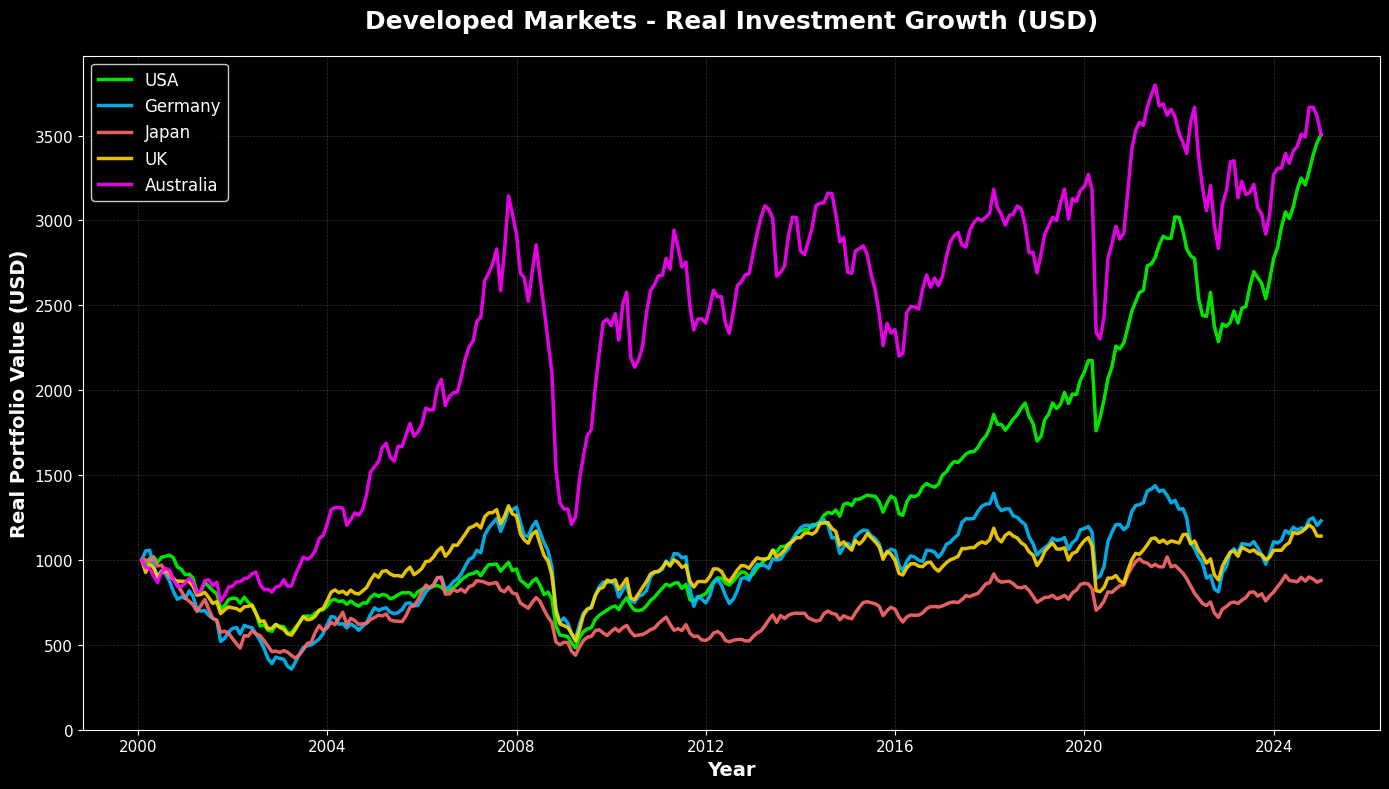

Chart displayed: Developed Markets (USD)


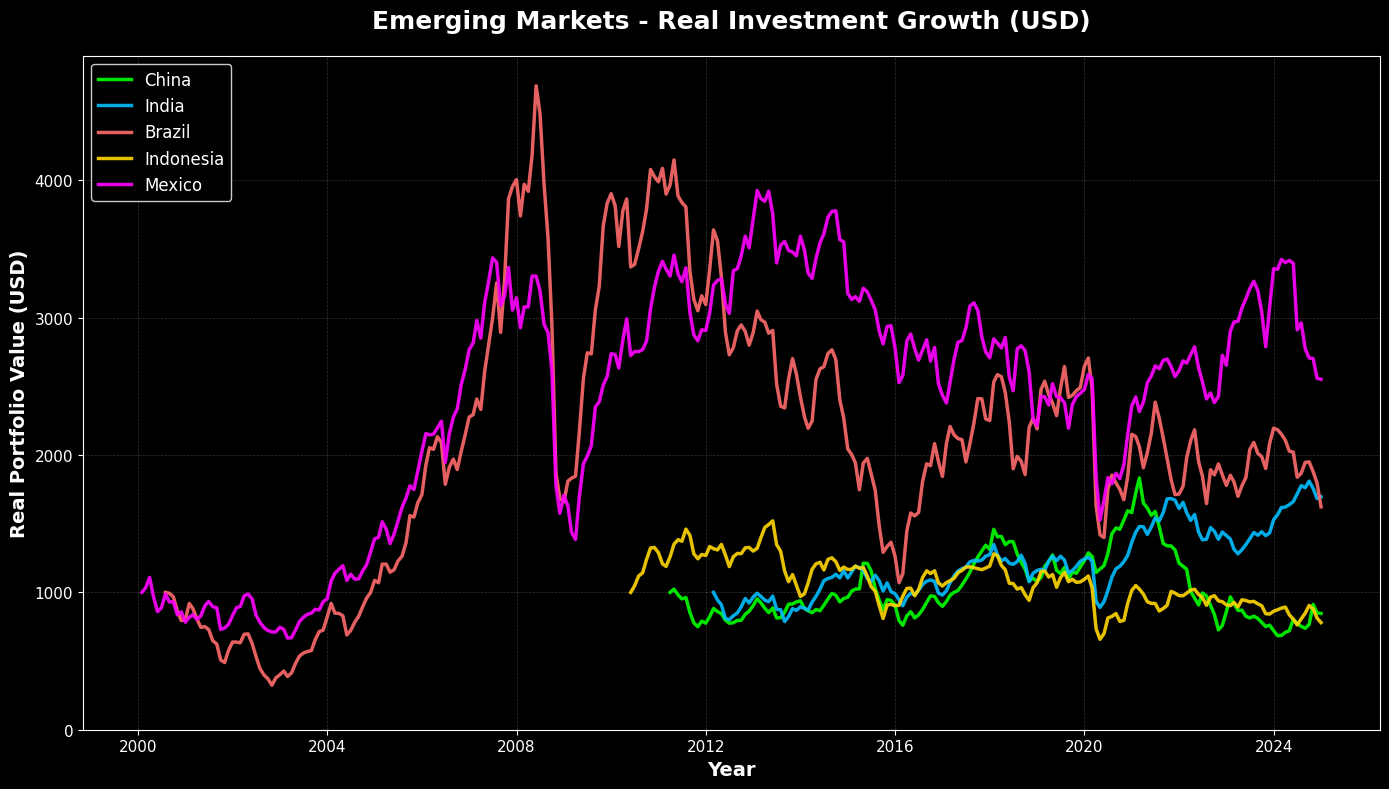

Chart displayed: Emerging Markets (USD)


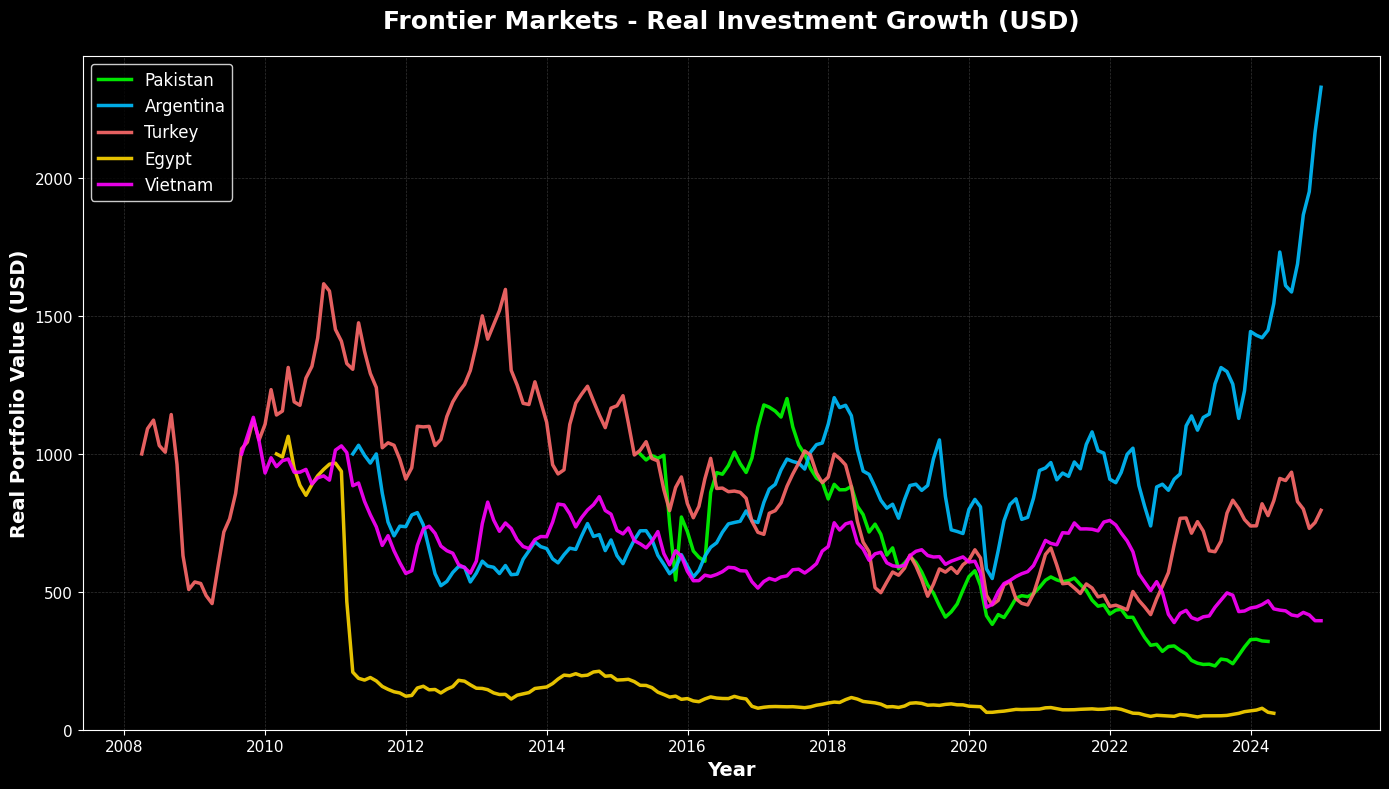

Chart displayed: Frontier Markets (USD)

All USD charts generated


In [57]:
# VISUALIZATION 1-3: USD Investment Growth (All Market Types)
print("="*80)
print("GENERATING USD INVESTMENT GROWTH CHARTS")
print("="*80)

# Developed Markets - USD
plot_market_growth(usd_data, 'Developed', 'USD', 1000)

# Emerging Markets - USD
plot_market_growth(usd_data, 'Emerging', 'USD', 1000)

# Frontier Markets - USD
plot_market_growth(usd_data, 'Frontier', 'USD', 1000)

print("\nAll USD charts generated")
print("="*80)

GENERATING LOCAL CURRENCY INVESTMENT GROWTH CHARTS


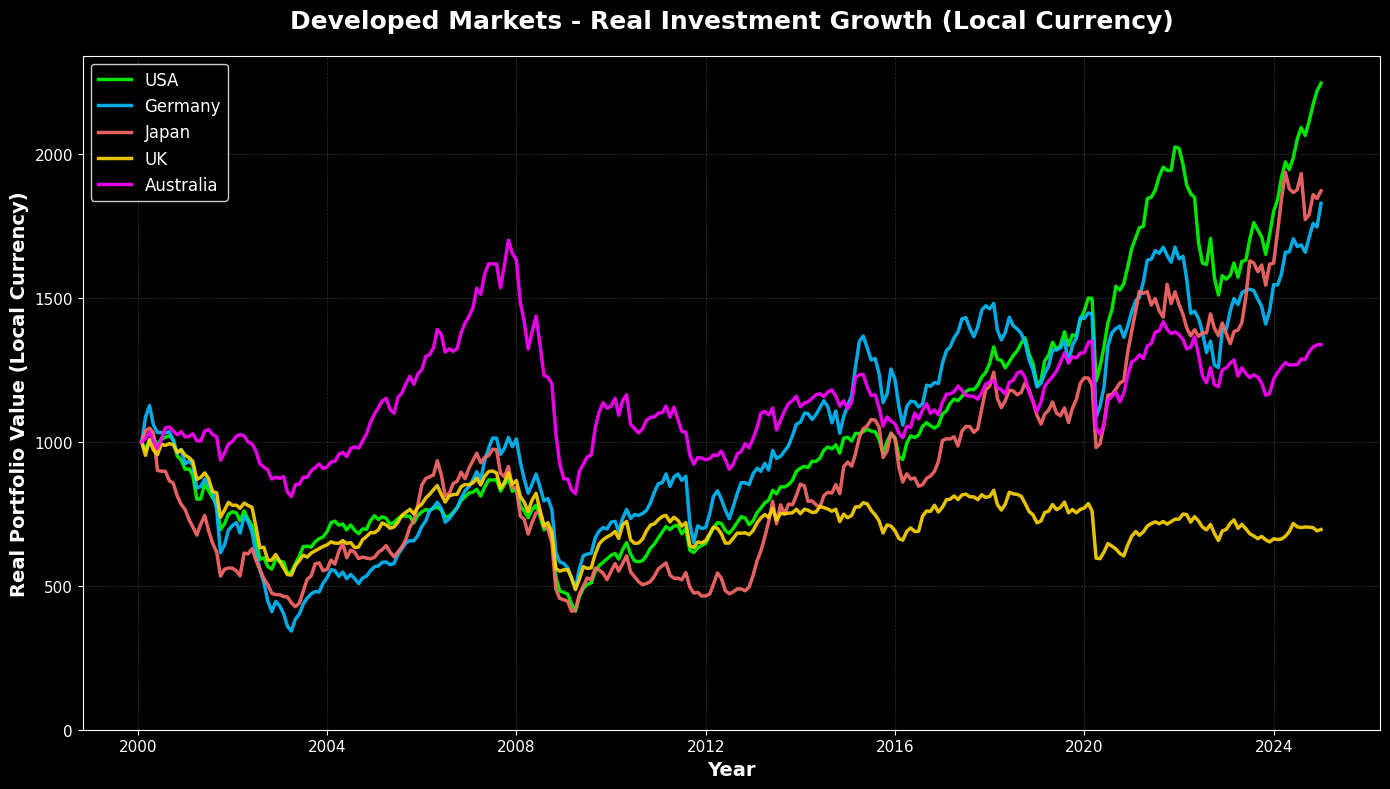

Chart displayed: Developed Markets (Local Currency)


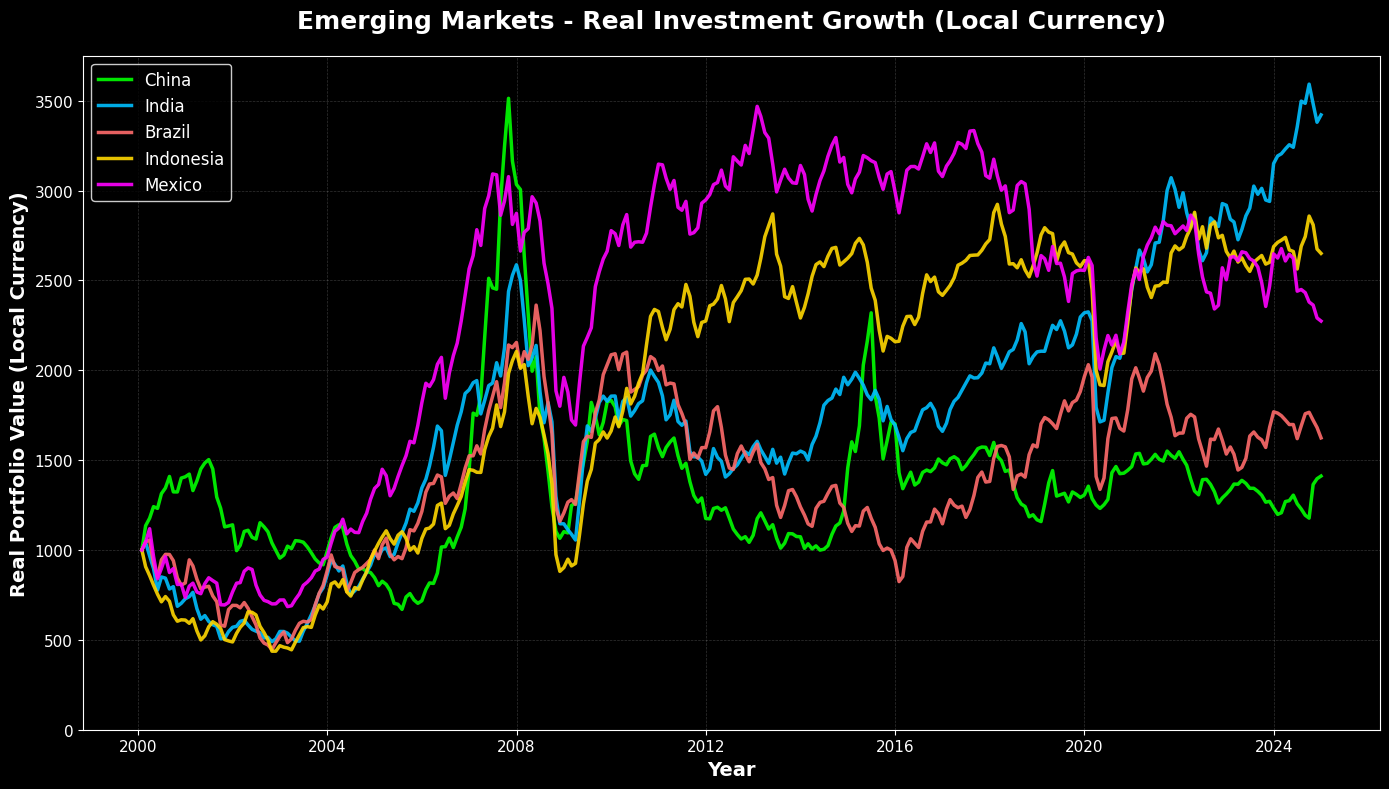

Chart displayed: Emerging Markets (Local Currency)


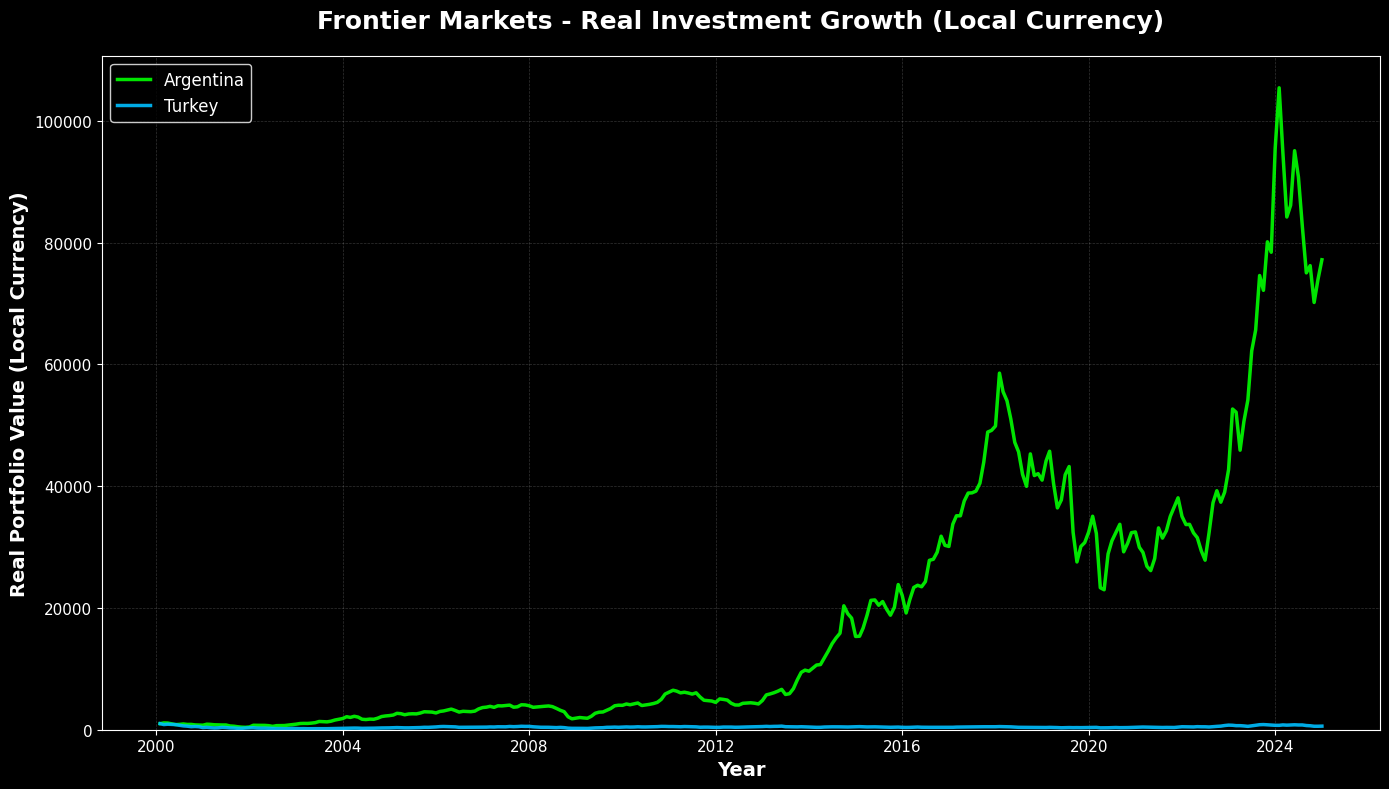

Chart displayed: Frontier Markets (Local Currency)

All Local Currency charts generated


In [58]:
# VISUALIZATION 4-6: Local Currency Investment Growth (All Market Types)
print("="*80)
print("GENERATING LOCAL CURRENCY INVESTMENT GROWTH CHARTS")
print("="*80)

# Developed Markets - Local Currency
plot_market_growth(local_currency_data, 'Developed', 'Local Currency', 1000)

# Emerging Markets - Local Currency
plot_market_growth(local_currency_data, 'Emerging', 'Local Currency', 1000)

# Frontier Markets - Local Currency
plot_market_growth(local_currency_data, 'Frontier', 'Local Currency', 1000)

print("\nAll Local Currency charts generated")
print("="*80)

In [59]:
# Function: Create Market Type Composite Index
def create_market_index(data_dict, market_type, start_date='2000-01-01'):
    """
    Create a composite index for a market type by averaging all countries.
    Equal-weighted average of normalized returns.
    
    Args:
        data_dict: Dictionary with country data
        market_type: 'Developed', 'Emerging', or 'Frontier'
        start_date: Common start date for all series
    
    Returns:
        Series representing the composite index
    """
    # Filter countries by market type
    countries_in_market = {
        country: data for country, data in data_dict.items()
        if data['market_type'] == market_type
    }
    
    if len(countries_in_market) == 0:
        print(f"No data for {market_type} markets")
        return None
    
    # Convert start_date to datetime
    start_dt = pd.to_datetime(start_date)
    
    # Normalize each country's data to start at 100
    normalized_series = []
    
    for country, data in countries_in_market.items():
        prices = data['prices']
        
        # Filter to start from common date
        prices_filtered = prices[prices.index >= start_dt]
        
        if len(prices_filtered) > 0:
            # Normalize to 100 at start
            first_price = prices_filtered.iloc[0]
            normalized = (prices_filtered / first_price) * 100
            normalized_series.append(normalized)
    
    if len(normalized_series) == 0:
        return None
    
    # Create a DataFrame with all series
    df = pd.concat(normalized_series, axis=1)
    
    # Calculate equal-weighted average (mean across countries for each date)
    composite_index = df.mean(axis=1)
    
    return composite_index

print("Market index creation function defined")
print("="*80)

Market index creation function defined


In [60]:
# Create Composite Indexes for USD Data
print("="*80)
print("CREATING USD COMPOSITE INDEXES")
print("="*80)

developed_index_usd = create_market_index(usd_data, 'Developed', '2000-01-01')
emerging_index_usd = create_market_index(usd_data, 'Emerging', '2000-01-01')
frontier_index_usd = create_market_index(usd_data, 'Frontier', '2000-01-01')

if developed_index_usd is not None:
    print(f"Developed Index (USD): {len(developed_index_usd)} months")
if emerging_index_usd is not None:
    print(f"Emerging Index (USD): {len(emerging_index_usd)} months")
if frontier_index_usd is not None:
    print(f"Frontier Index (USD): {len(frontier_index_usd)} months")

print("="*80)

CREATING USD COMPOSITE INDEXES
Developed Index (USD): 300 months
Emerging Index (USD): 300 months
Frontier Index (USD): 202 months


In [61]:
# Create Composite Indexes for Local Currency Data
print("="*80)
print("CREATING LOCAL CURRENCY COMPOSITE INDEXES")
print("="*80)

developed_index_local = create_market_index(local_currency_data, 'Developed', '2000-01-01')
emerging_index_local = create_market_index(local_currency_data, 'Emerging', '2000-01-01')
frontier_index_local = create_market_index(local_currency_data, 'Frontier', '2000-01-01')

if developed_index_local is not None:
    print(f"Developed Index (Local): {len(developed_index_local)} months")
if emerging_index_local is not None:
    print(f"Emerging Index (Local): {len(emerging_index_local)} months")
if frontier_index_local is not None:
    print(f"Frontier Index (Local): {len(frontier_index_local)} months")

print("="*80)

CREATING LOCAL CURRENCY COMPOSITE INDEXES
Developed Index (Local): 300 months
Emerging Index (Local): 300 months
Frontier Index (Local): 300 months


In [62]:
# Function: Plot Market Type Comparison
def plot_market_comparison(developed_idx, emerging_idx, frontier_idx, currency_label, initial_investment=1000):
    """
    Plot comparison of three market types on one chart.
    
    Args:
        developed_idx: Developed markets composite index
        emerging_idx: Emerging markets composite index
        frontier_idx: Frontier markets composite index
        currency_label: 'USD' or 'Local Currency'
        initial_investment: Starting amount
    """
    plt.figure(figsize=(16, 9))
    
    # Convert indexes to investment values (from base 100 to initial_investment)
    if developed_idx is not None and len(developed_idx) > 0:
        developed_value = (developed_idx / 100) * initial_investment
        plt.plot(developed_value.index, developed_value.values, 
                label='Developed Markets', linewidth=3.5, color='#00ff00', alpha=0.95)
    
    if emerging_idx is not None and len(emerging_idx) > 0:
        emerging_value = (emerging_idx / 100) * initial_investment
        plt.plot(emerging_value.index, emerging_value.values, 
                label='Emerging Markets', linewidth=3.5, color='#00bfff', alpha=0.95)
    
    if frontier_idx is not None and len(frontier_idx) > 0:
        frontier_value = (frontier_idx / 100) * initial_investment
        plt.plot(frontier_value.index, frontier_value.values, 
                label='Frontier Markets', linewidth=3.5, color='#ff6b6b', alpha=0.95)
    
    # Formatting
    plt.title(f'Market Type Comparison - Real Investment Growth ({currency_label})', 
             fontsize=20, fontweight='bold', color='white', pad=20)
    plt.xlabel('Year', fontsize=16, fontweight='bold', color='white')
    plt.ylabel(f'Real Portfolio Value ({currency_label})', fontsize=16, fontweight='bold', color='white')
    
    # Grid
    plt.grid(True, alpha=0.25, linestyle='--', linewidth=0.7)
    
    # Legend
    plt.legend(fontsize=14, loc='upper left', framealpha=0.9, facecolor='black', edgecolor='white', borderpad=1)
    
    # Set background
    plt.gca().set_facecolor('#000000')
    plt.gcf().patch.set_facecolor('#000000')
    
    # Tick colors
    plt.tick_params(colors='white', labelsize=12)
    
    # Linear scale
    plt.yscale('linear')
    
    # Start y-axis from 0
    plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Market Comparison Chart displayed ({currency_label})")
    print("="*80)

print("Market comparison plotting function defined")
print("="*80)

Market comparison plotting function defined


GENERATING USD MARKET TYPE COMPARISON


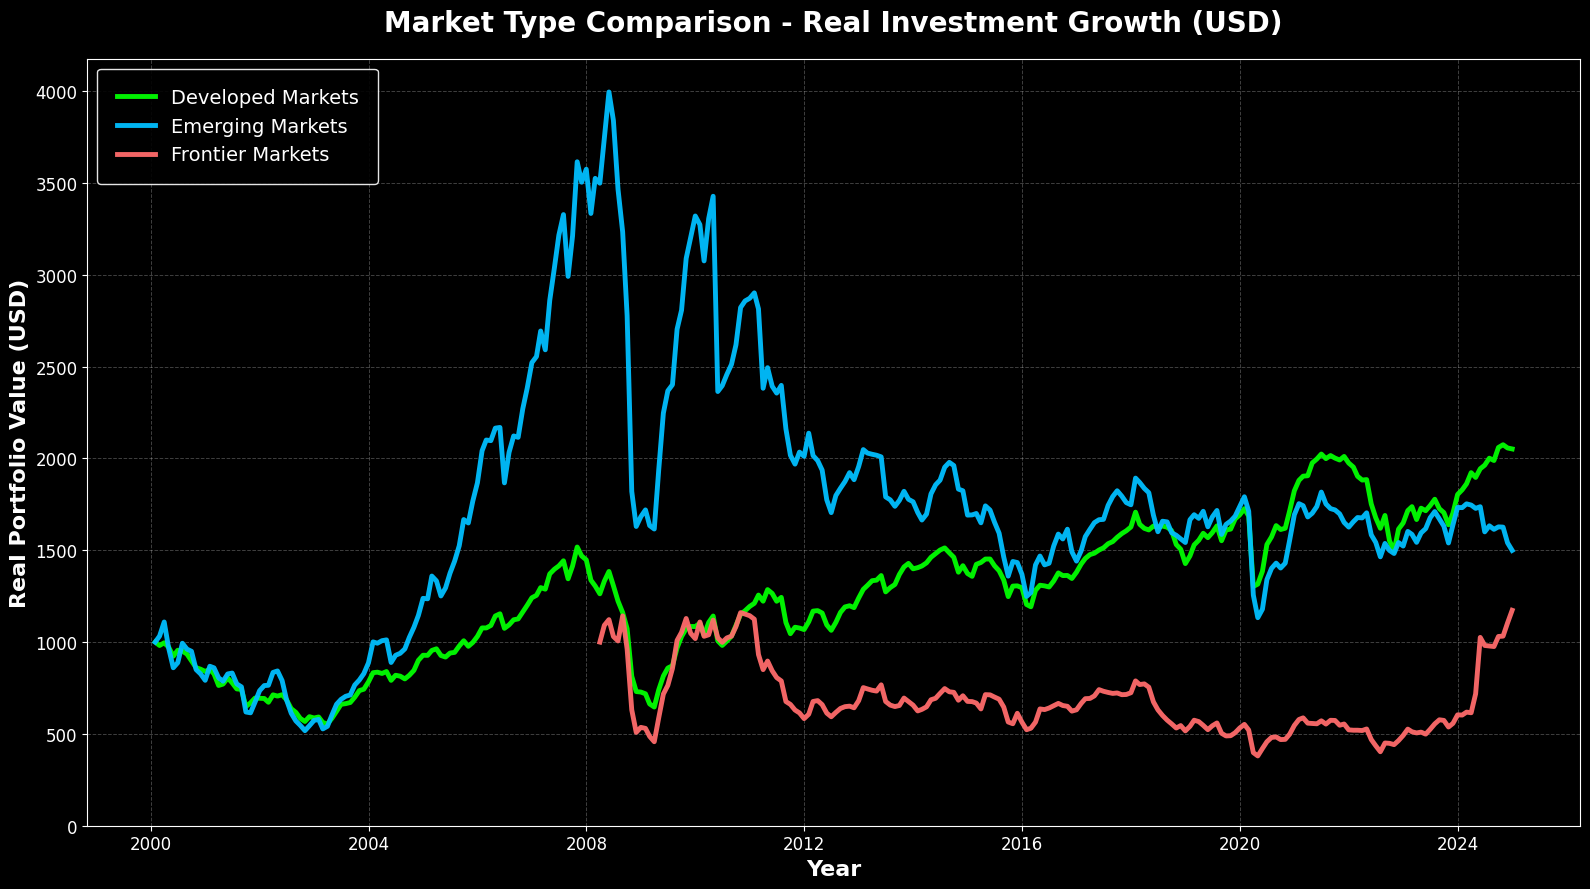

Market Comparison Chart displayed (USD)

USD comparison chart complete


In [63]:
# COMPOSITE GRAPH 1: USD Market Type Comparison
print("="*80)
print("GENERATING USD MARKET TYPE COMPARISON")
print("="*80)

plot_market_comparison(developed_index_usd, emerging_index_usd, frontier_index_usd, 'USD', 1000)

print("\nUSD comparison chart complete")
print("="*80)

GENERATING LOCAL CURRENCY MARKET TYPE COMPARISON


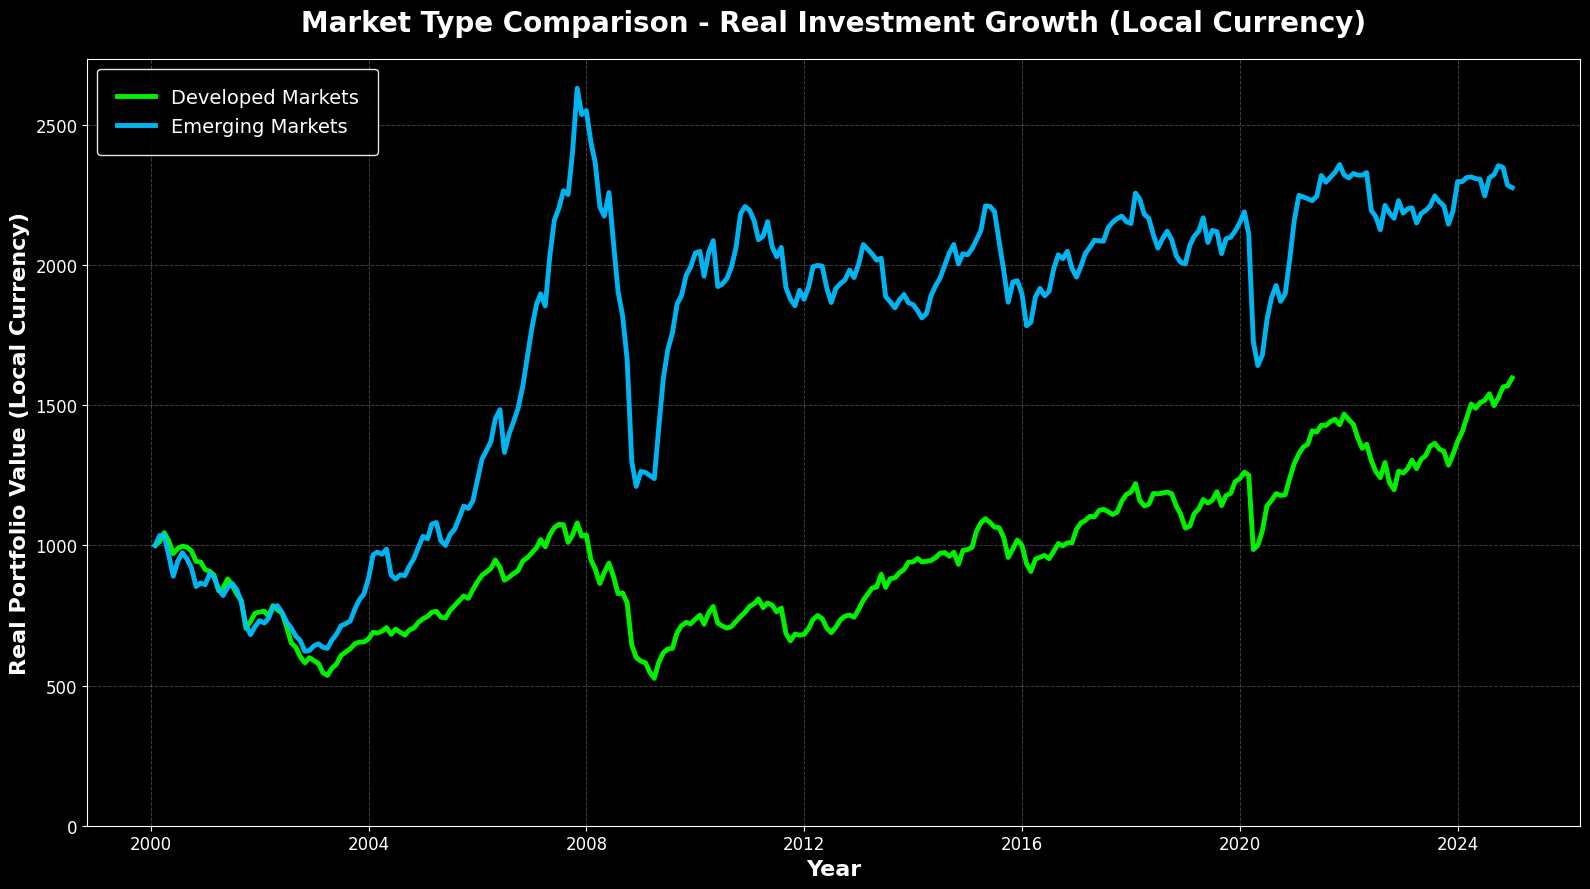

Market Comparison Chart displayed (Local Currency)

Local Currency comparison chart complete (Developed & Emerging markets only)


In [64]:
# COMPOSITE GRAPH 2: Local Currency Market Type Comparison (Developed & Emerging Only)
print("="*80)
print("GENERATING LOCAL CURRENCY MARKET TYPE COMPARISON")
print("="*80)

# Exclude frontier markets from local currency comparison due to extreme volatility
plot_market_comparison(developed_index_local, emerging_index_local, None, 'Local Currency', 1000)

print("\nLocal Currency comparison chart complete (Developed & Emerging markets only)")
print("="*80)

In [66]:
# $1000 Investment Analysis: 25-Year Real Returns (2000-2025)
print("="*80)
print("$1000 INVESTMENT ANALYSIS - 25 YEAR REAL RETURNS")
print("="*80)

# Select countries with complete 25-year data (300 months)
full_data_countries = ['USA', 'Germany', 'Japan', 'UK', 'Australia', 'Mexico']

# Calculate final portfolio values
investment_results = {}

for country in full_data_countries:
    if country in usd_data:
        prices = usd_data[country]['prices']
        
        # Check if we have enough data
        if len(prices) >= 300:
            first_price = prices.iloc[0]
            last_price = prices.iloc[-1]
            
            # Calculate final value from $1000 initial investment
            final_value = (last_price / first_price) * 1000
            
            # Calculate total return percentage
            total_return_pct = ((last_price / first_price) - 1) * 100
            
            investment_results[country] = {
                'final_value': final_value,
                'return_pct': total_return_pct,
                'market_type': usd_data[country]['market_type']
            }
            
            print(f"{country:12} | ${final_value:,.2f} | {total_return_pct:+.1f}%")

print("="*80)
print(f"\nAnalyzed {len(investment_results)} countries with complete 25-year data")
print("Returns are REAL (inflation-adjusted) in USD")
print("="*80)

$1000 INVESTMENT ANALYSIS - 25 YEAR REAL RETURNS
USA          | $3,505.55 | +250.6%
Germany      | $1,230.25 | +23.0%
Japan        | $879.44 | -12.1%
UK           | $1,140.64 | +14.1%
Australia    | $3,504.59 | +250.5%
Mexico       | $2,551.48 | +155.1%

Analyzed 6 countries with complete 25-year data
Returns are REAL (inflation-adjusted) in USD


In [68]:
# VERIFICATION: Check data quality and calculation method
print("="*80)
print("DATA VERIFICATION")
print("="*80)

for country in full_data_countries:
    if country in usd_data:
        prices = usd_data[country]['prices']
        
        if len(prices) >= 300:
            print(f"\n{country}:")
            print(f"  Total months: {len(prices)}")
            print(f"  Start date: {prices.index[0].strftime('%Y-%m')}")
            print(f"  End date: {prices.index[-1].strftime('%Y-%m')}")
            print(f"  First price (Jan 2000): {prices.iloc[0]:.2f}")
            print(f"  Last price (Dec 2024): {prices.iloc[-1]:.2f}")
            print(f"  Price ratio: {prices.iloc[-1] / prices.iloc[0]:.3f}x")
            
            # Calculate annualized real return
            years = len(prices) / 12
            total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
            annualized_return = ((1 + total_return) ** (1/years) - 1) * 100
            print(f"  Annualized real return: {annualized_return:.2f}% per year")

print("\n" + "="*80)
print("NOTE: These are REAL prices (already adjusted for US inflation)")
print("The prices show purchasing power, not nominal dollar values")
print("="*80)

DATA VERIFICATION

USA:
  Total months: 300
  Start date: 2000-01
  End date: 2024-12
  First price (Jan 2000): 89.93
  Last price (Dec 2024): 315.26
  Price ratio: 3.506x
  Annualized real return: 5.15% per year

Germany:
  Total months: 300
  Start date: 2000-01
  End date: 2024-12
  First price (Jan 2000): 13.90
  Last price (Dec 2024): 17.11
  Price ratio: 1.230x
  Annualized real return: 0.83% per year

Japan:
  Total months: 300
  Start date: 2000-01
  End date: 2024-12
  First price (Jan 2000): 39.54
  Last price (Dec 2024): 34.77
  Price ratio: 0.879x
  Annualized real return: -0.51% per year

UK:
  Total months: 300
  Start date: 2000-01
  End date: 2024-12
  First price (Jan 2000): 15.52
  Last price (Dec 2024): 17.70
  Price ratio: 1.141x
  Annualized real return: 0.53% per year

Australia:
  Total months: 300
  Start date: 2000-01
  End date: 2024-12
  First price (Jan 2000): 3.65
  Last price (Dec 2024): 12.78
  Price ratio: 3.505x
  Annualized real return: 5.14% per year


  ✓ USA
  ✓ Germany
  ✓ Japan
  ✓ UK
  ✓ Australia
  ✓ Mexico

Creating visualization...


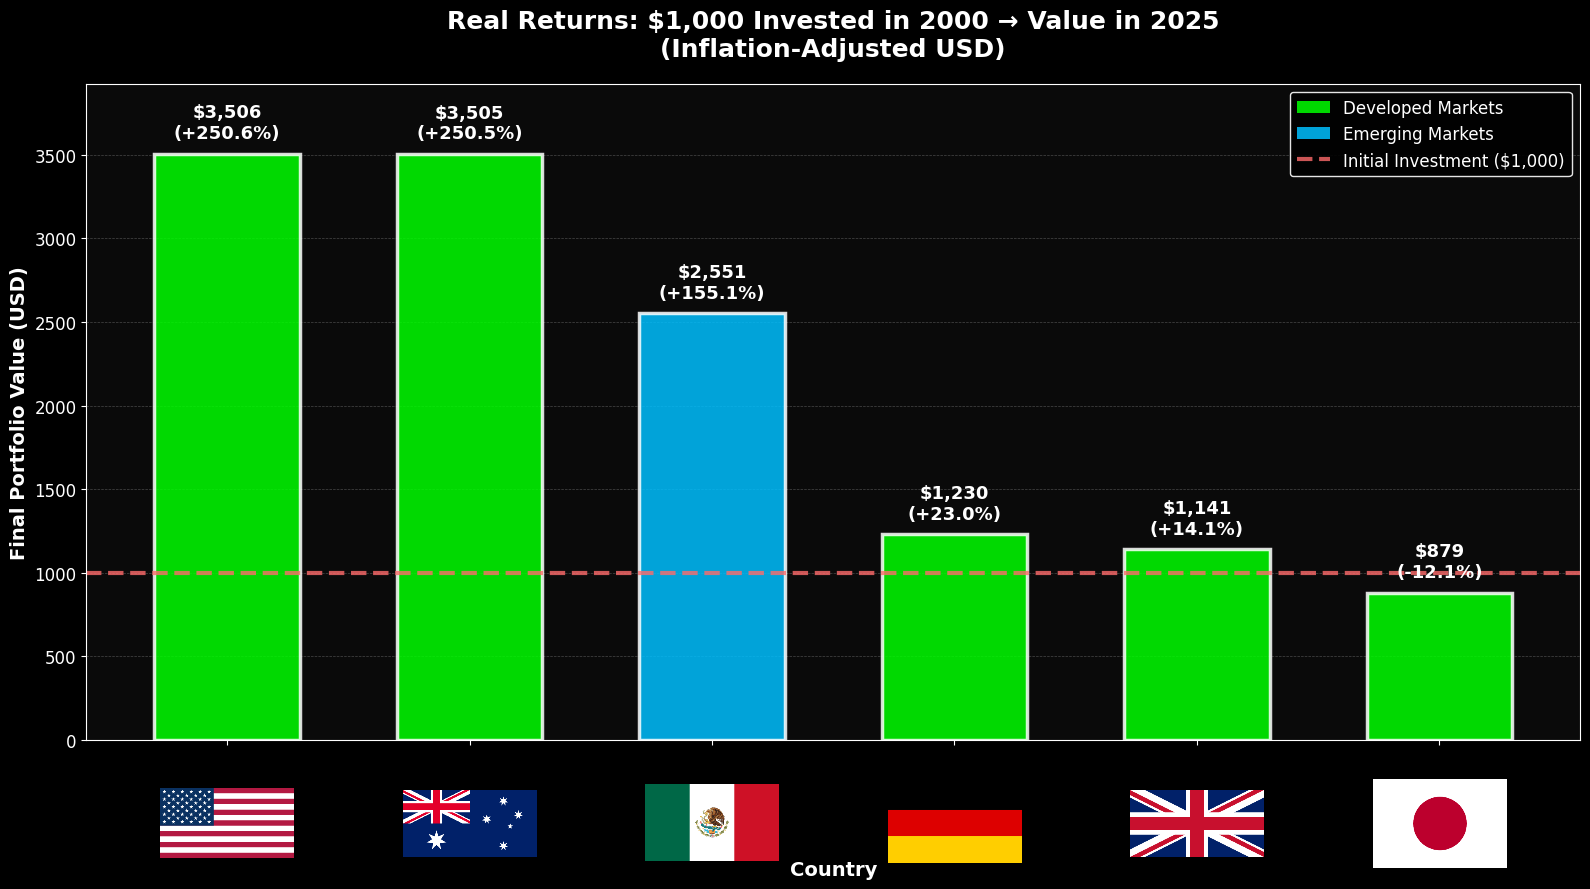

VISUALIZATION COMPLETE

Key Insights:
  1. USA: $3,506 (+250.6%)
  2. Australia: $3,505 (+250.5%)
  3. Mexico: $2,551 (+155.1%)
  4. Germany: $1,230 (+23.0%)
  5. UK: $1,141 (+14.1%)
  6. Japan: $879 (-12.1%)

  Average final value: $2,135

  Note: All returns adjusted for USD inflation (real purchasing power)


In [80]:
# Visualization: $1000 Investment Growth with Flags Behind Labels

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image
import requests
from io import BytesIO
import numpy as np

# ============================================================================
# ADJUST FLAG SIZE HERE: Change this number (0.15 = small, 0.5 = large)
FLAG_SIZE = 0.3
# ============================================================================

# Country flag URLs (using flagcdn.com - free flag CDN)
flag_urls = {
    'USA': 'https://flagcdn.com/w320/us.png',
    'Germany': 'https://flagcdn.com/w320/de.png',
    'Japan': 'https://flagcdn.com/w320/jp.png',
    'UK': 'https://flagcdn.com/w320/gb.png',
    'Australia': 'https://flagcdn.com/w320/au.png',
    'Mexico': 'https://flagcdn.com/w320/mx.png'
}

# Download flags
print("Downloading flag images...")
flag_images = {}
for country, url in flag_urls.items():
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content))
        
        # Convert to RGB to ensure correct colors
        img = img.convert('RGB')
        
        flag_images[country] = np.array(img)
        print(f"  ✓ {country}")
    except Exception as e:
        print(f"  ✗ {country}: {e}")
        flag_images[country] = None

print("\nCreating visualization...")

# Sort countries by final value
sorted_countries = sorted(investment_results.items(), 
                         key=lambda x: x[1]['final_value'], 
                         reverse=True)

countries = [item[0] for item in sorted_countries]
final_values = [item[1]['final_value'] for item in sorted_countries]

# Create figure
fig, ax = plt.subplots(figsize=(16, 9))

# Color mapping
colors_map = {
    'Developed': '#00ff00',
    'Emerging': '#00bfff'
}
bar_colors = [colors_map[investment_results[country]['market_type']] for country in countries]

# Create bars
bar_width = 0.6
x_positions = range(len(countries))
bars = ax.bar(x_positions, final_values, width=bar_width, 
              color=bar_colors, alpha=0.85, edgecolor='white', linewidth=2.5)

# Add value labels on top of bars
for i, (country, value) in enumerate(zip(countries, final_values)):
    return_pct = investment_results[country]['return_pct']
    ax.text(i, value + max(final_values) * 0.02,
            f'${value:,.0f}\n({return_pct:+.1f}%)',
            ha='center', va='bottom', fontsize=13, fontweight='bold', 
            color='white')

# Add initial investment reference line
ax.axhline(y=1000, color='#ff6b6b', linestyle='--', linewidth=3, 
           label='Initial Investment ($1,000)', alpha=0.8)

# Add flags behind x-axis labels
for i, country in enumerate(countries):
    if flag_images.get(country) is not None:
        # Create OffsetImage with the flag (using FLAG_SIZE variable)
        imagebox = OffsetImage(flag_images[country], zoom=FLAG_SIZE)
        
        # Position the flag below the x-axis at each country position
        ab = AnnotationBbox(imagebox, (i, 0), 
                           xybox=(0, -60), 
                           xycoords='data',
                           boxcoords="offset points",
                           frameon=False,
                           zorder=1)
        ax.add_artist(ab)

# Set x-axis labels (white text)
ax.set_xticks(x_positions)
ax.set_xticklabels(countries, fontsize=13, fontweight='bold', color='white')

# Adjust x-axis label position to be below flags
ax.tick_params(axis='x', pad=50)

# Formatting
ax.set_title('Real Returns: $1,000 Invested in 2000 → Value in 2025\n(Inflation-Adjusted USD)', 
            fontsize=18, fontweight='bold', color='white', pad=20)
ax.set_xlabel('Country', fontsize=14, fontweight='bold', color='white', labelpad=20)
ax.set_ylabel('Final Portfolio Value (USD)', fontsize=14, fontweight='bold', color='white')

# Grid
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5, axis='y')
ax.set_axisbelow(True)

# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, fc='#00ff00', alpha=0.85, label='Developed Markets'),
    plt.Rectangle((0,0),1,1, fc='#00bfff', alpha=0.85, label='Emerging Markets'),
    plt.Line2D([0], [0], color='#ff6b6b', linewidth=3, linestyle='--', 
               label='Initial Investment ($1,000)', alpha=0.8)
]
ax.legend(handles=legend_elements, fontsize=12, loc='upper right', 
         framealpha=0.9, facecolor='black', edgecolor='white')

# Set background
ax.set_facecolor('#0a0a0a')
fig.patch.set_facecolor('#000000')

# Tick colors
ax.tick_params(colors='white', labelsize=12)

# Set y-axis limits
y_max = max(final_values)
ax.set_ylim(0, y_max * 1.12)

plt.tight_layout()
plt.show()

print("="*80)
print("VISUALIZATION COMPLETE")
print("="*80)
print("\nKey Insights:")
for i, (country, data) in enumerate(sorted_countries, 1):
    print(f"  {i}. {country}: ${data['final_value']:,.0f} ({data['return_pct']:+.1f}%)")
avg_value = sum(final_values) / len(final_values)
print(f"\n  Average final value: ${avg_value:,.0f}")
print("\n  Note: All returns adjusted for USD inflation (real purchasing power)")
print("="*80)